In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import minimize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Excess Mortality

In [2]:
# Read in covid excess mortality data
# Excess mortality is observed mortality in a year over some runnig average
excess_mort = pd.read_csv("national_excess_mortality.csv")
excess_mort.head()

,COUNTRY,Country,WEEK,GENDER,Gender,Age,VARIABLE,Variable,YEAR,Year,Value
0,CZE,Czech Republic,46,TOTAL,Total,0 to 44,EXCESSNB,Excess deaths (number),2020,2020,2.2
1,CZE,Czech Republic,46,TOTAL,Total,0 to 44,EXCESSNB,Excess deaths (number),2021,2021,8.2
2,NLD,Netherlands,3,TOTAL,Total,65 and over,EXCESSNB,Excess deaths (number),2020,2020,-127.4
3,NLD,Netherlands,3,TOTAL,Total,65 and over,EXCESSNB,Excess deaths (number),2021,2021,569.6
4,NLD,Netherlands,3,TOTAL,Total,65 and over,EXCESSNB,Excess deaths (number),2022,2022,-73.4


### Data Cleaning

In [3]:
# drop redundant columns
excess_mort = excess_mort.drop(['VARIABLE', 'YEAR', 'GENDER'], axis=1)

# two different metric options to use 
# percent is best for comparing between countries
excess_mort_num = excess_mort[excess_mort['Variable'] == 'Excess deaths (number)'].drop('Variable', axis=1)
excess_mort = excess_mort[excess_mort['Variable'] == 'Excess deaths (% change from average)'].drop('Variable', axis=1)

# each row represents the excess mortality for in a given week for a gendered age group in a country
excess_mort.head()

,COUNTRY,Country,WEEK,Gender,Age,Year,Value
38466,DNK,Denmark,29,Males,45 to 64,2020,1.0
38467,DNK,Denmark,29,Males,45 to 64,2021,4.7
38468,EST,Estonia,47,Males,45 to 64,2020,32.4
38469,EST,Estonia,47,Males,45 to 64,2021,35.3
38473,LUX,Luxembourg,40,Males,Total,2020,-4.0


I want to look at the change in excess mortality through time. So I need to create a column to represent continous time. The first `Year` and `WEEK` are Week 1 2020, so I'm gonna create a variable thats weeks after Jan 1, 2020 called `Time`. To do this I also want to get only the total values to compare countries.

In [4]:
excess_mort['Time'] = (52 * (excess_mort['Year'] - 2020)) + (excess_mort['WEEK'] - 1)
excess_mort.sort_values(['Year', 'WEEK']).head()

,COUNTRY,Country,WEEK,Gender,Age,Year,Value,Time
38505,ISL,Iceland,1,Total,65 and over,2020,17.9,0
38545,CAN,Canada,1,Males,0 to 44,2020,12.7,0
38631,LTU,Lithuania,1,Males,0 to 44,2020,-23.3,0
38676,SWE,Sweden,1,Males,0 to 44,2020,10.2,0
38892,BEL,Belgium,1,Females,45 to 64,2020,6.9,0


In [5]:
# subset your data Total Gender and Total Age 
excess_mort_total = excess_mort[(excess_mort['Gender'] == 'Total') & (excess_mort['Age'] == 'Total')]
excess_mort_total.head()

,COUNTRY,Country,WEEK,Gender,Age,Year,Value,Time
38475,BEL,Belgium,18,Total,Total,2020,20.7,17
38476,BEL,Belgium,18,Total,Total,2021,12.5,69
38477,BEL,Belgium,18,Total,Total,2022,11.5,121
38497,DNK,Denmark,37,Total,Total,2020,3.6,36
38498,DNK,Denmark,37,Total,Total,2021,10.6,88


### Data Visualization

Text(0.5, 0, 'Weeks After Jan 1, 2020')

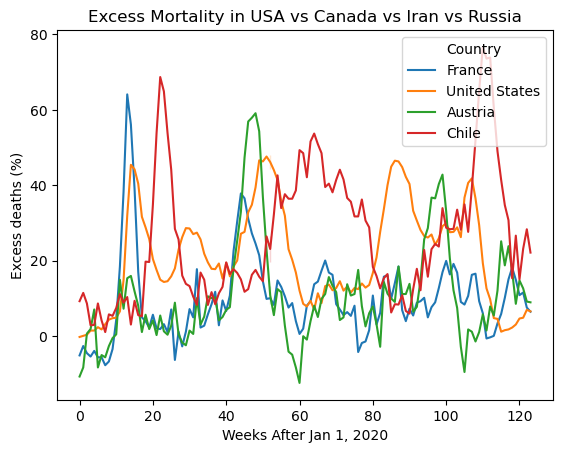

In [6]:
# lets looks at a few countries over time that don't have a unique quality  
# its pretty messy but we can compare and see what was high to relative to other countries
excess_mort_4 = excess_mort_total[excess_mort_total['Country'].isin(['Austria' , 'United States', 'Chile', 'France'])]

sns.lineplot(data=excess_mort_4, x='Time', y='Value', hue='Country')
plt.title('Excess Mortality in USA vs Canada vs Iran vs Russia')
plt.ylabel('Excess deaths (%)')
plt.xlabel('Weeks After Jan 1, 2020')

Text(0.5, 0, 'Weeks After Jan 1, 2020')

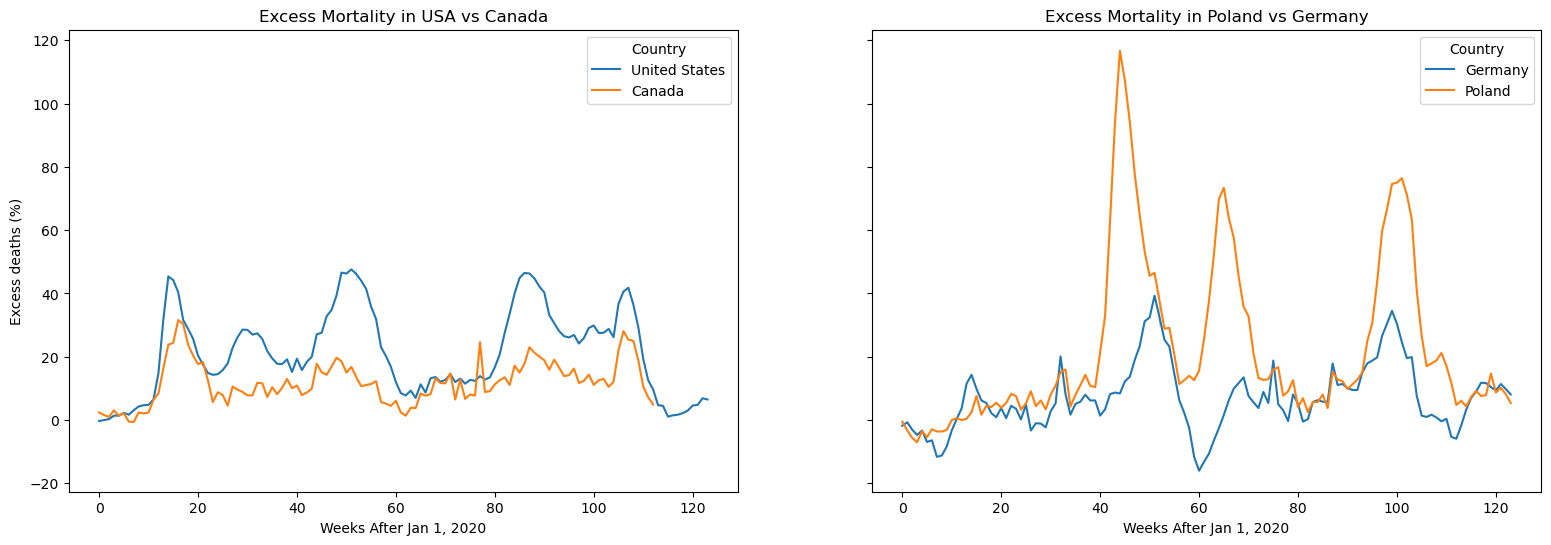

In [7]:
# when you choose geogragphically close countries and compare them you can see how excess mortality rises and falls similarly
excess_mort_US_CAN = excess_mort_total[excess_mort_total['Country'].isin(['Canada' , 'United States'])]
excess_mort_POL_GER = excess_mort_total[excess_mort_total['Country'].isin(['Germany' , 'Poland'])]

fig, axes = plt.subplots(1, 2, figsize=(19, 6), sharey=True)

sns.lineplot(data=excess_mort_US_CAN, x='Time', y='Value', hue='Country', ax=axes[0])
axes[0].set_title('Excess Mortality in USA vs Canada')
axes[0].set_ylabel('Excess deaths (%)')
axes[0].set_xlabel('Weeks After Jan 1, 2020')

sns.lineplot(data=excess_mort_POL_GER, x='Time', y='Value', hue='Country', ax=axes[1])
axes[1].set_title('Excess Mortality in Poland vs Germany')
axes[1].set_ylabel('Excess deaths (%)')
axes[1].set_xlabel('Weeks After Jan 1, 2020')

The main thing I noticed about excess mortality through time is that its extreamely varied. This data was taken from the period right before COVID tell when things started to go back to normal so the spikes are pretty clearly outbreaks. One thing I see that confirms many things I saw about COVID in various countries is that the US is consistenly high with less extream spikes, but most other countries average lower and spike higher. We can also see how geographical location plays into outbreaks when countries that share a boarder have an excess mortality that rises and falls similarly.

Text(0.5, 0, 'Weeks After Jan 1, 2020')

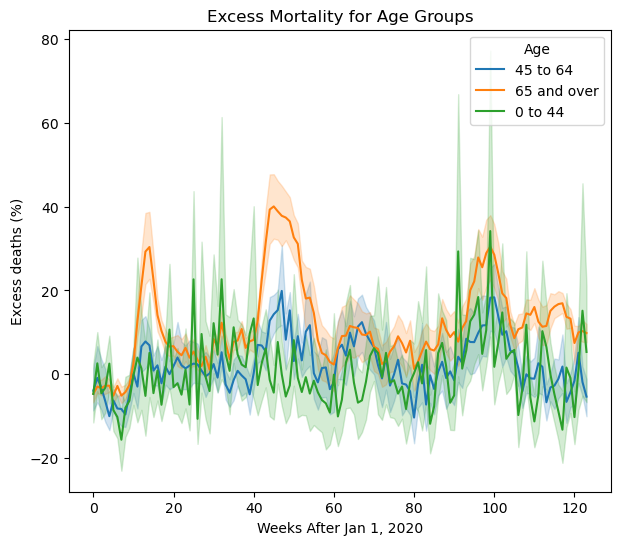

In [8]:
plt.figure(figsize=(7,6))
sns.lineplot(data=excess_mort[excess_mort['Age']!= 'Total'], x='Time', y='Value', hue='Age')
plt.title('Excess Mortality for Age Groups')
plt.ylabel('Excess deaths (%)')
plt.xlabel('Weeks After Jan 1, 2020')

This new comparison looks at excess mortality in different age groups. As we might expect older people have the highst rate and youngest people the lowest. But this chart could also be an insight into how much of the excess mortality could be related to higher populations of older people. Such as if there was data over a longer period of time it would be visable when baby boomers start dying because there is going to be a higher amount of mortality due to old age that results from having a larger (in numbers) generation. 

I might want to know if excess mortality was on a general rise or incline for all the countries represented in the data set. 

The slope of the linear regression is 1.7812170890852075 showing a small general rise in excess mortality during COVID.


Text(0.5, 1.0, 'Excess Mortality During COVID 19')

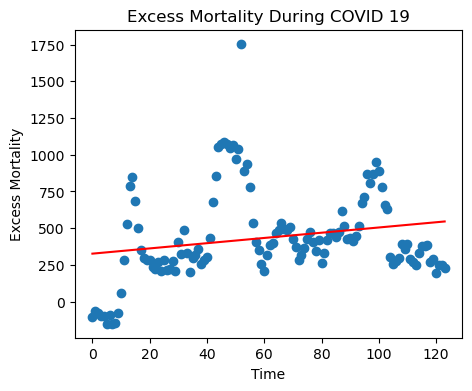

In [10]:
excess_mort_sum = excess_mort_total.groupby('Time')['Value'].sum()

def l2_tip_risk_list(theta):
    # Returns average l2 loss between regression line for intercept a and slope b
    x = excess_mort_sum.index
    y = excess_mort_sum.values
    sum = np.sum((y-(theta[0]+(theta[1]*x)))**2)
    return sum / len(x)

minimized = minimize(l2_tip_risk_list, x0=[0,0])
print("The slope of the linear regression is", minimized['x'][1], "showing a small general rise in excess mortality during COVID.")

plt.figure(figsize=(5,4))
plt.scatter(excess_mort_sum.index, excess_mort_sum.values)
plt.plot(excess_mort_sum.index, (minimized['x'][1] * excess_mort_sum.index) + minimized['x'][0], color='red')
plt.xlabel('Time')
plt.ylabel('Excess Mortality')
plt.title('Excess Mortality During COVID 19')